# This explores Elon Musk's Idea of an electric supersonic vertical takeoff and landing passenger jet
See https://www.youtube.com/watch?v=RyS92KPQnjk for the basis of this notebook.

The propulsion is assumed to be, effectively, electric compressors connected to a de Laval nozzle.

The goal of this notebook is to determine what the range of such a jet could be, in both the supersonic and non-supersonic cases. The notebook defines a model for the jet, then optimizes that model to maximize range for a given number of passengers and other constraints, like the required FAA holding period, maximum engine size, etc.

The body composition of the jet is based off of either the 787 or the Concorde. The wings, battery size, overall scale of the plane, propulsion parameters, etc. are all modeled and controllable by the optimization. 

In [1]:
from __future__ import division
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, optimize

pd.set_option('max_columns', 99)
%matplotlib inline

In [2]:
R = 8314.46 # J/(kmol*K)
gamma = 1.40 # air
M = 28.895 # kg/kmol, air
gravitational_constant = 6.674e-11
earth_mass = 5.972e24 # kg
earth_radius = 6375000 # m

# From http://www.digitaldutch.com/atmoscalc/tableatmosphere.htm
atm_data = pd.read_csv('st_atm_1976.csv').set_index('Altitude [m]')
atmosphere = interpolate.interp1d(atm_data.index, [atm_data[c] for c in atm_data])
T_ground, P_ground, rho_ground, c_ground, u_ground = atmosphere(0)

In [3]:
def comp_pr_to_temp(T_in, PR):
    return T_in * PR ** ((gamma - 1)/gamma)


def exit_velocity(T, R, M, PR, gamma=gamma):
    if PR > 1:
        return ( T*R/M * 2*gamma/(gamma - 1) * (1 - (1/PR)**((gamma-1)/gamma)) )**0.5
    else:
        return 0


def adia_W_to_pressure(mass, Ti, W, gamma=gamma, R=R, M=M):
    return ( (gamma - 1) / gamma * W / (R * Ti) * M / mass + 1 ) ** (gamma/(gamma-1))


def nozzle_exit_temp(T_in, Me, gamma):
    return T_in/(1 + (gamma-1)/2 * Me**2)


def stagnation_pressure_ratio(mach_number, gamma=gamma):
    return (1 + (gamma-1)/2 * mach_number**2) ** (gamma/(gamma-1))


def stagnation_temp_ratio(mach_number, gamma=gamma):
    return 1 + (gamma-1)/2 * mach_number**2


def air_density(P, T, R=287.058):
    return P / (R * T)


def temp_to_sos(T):
    # Speed of sound in dry air
    return 20.05 * T**0.5


def propeller_thrust(diameter, power, rho):
    # Derived from http://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node86.html
    r = diameter / 2
    area = np.pi * r ** 2
    return (2 * power ** 2 * rho * area) ** (1/3)

In [4]:
def get_engine(power, T, rho, P, mdot, airspeed,
                    inlet_efficiency, motor_efficiency, compressor_efficiency, nozzle_efficiency):
    engine_flow_Ma = 0.45 # Relative to inlet speed of sound

    mach_number = airspeed / temp_to_sos(T)

    # Fast-moving air is stagnated:
    if mach_number > 1:
        pressure_recovery = inlet_efficiency * (1 - 0.07 * (mach_number - 1)**1.35)
    else: 
        pressure_recovery = inlet_efficiency

    PR_stag = stagnation_pressure_ratio(mach_number) * pressure_recovery
    P *= PR_stag
    T = T * stagnation_temp_ratio(mach_number)
    rho = air_density(P, T)

    # Air is compressed with compressor
    PR_comp = adia_W_to_pressure(mdot, T, power*motor_efficiency*compressor_efficiency)
    T = comp_pr_to_temp(T, PR_comp)
    PR_tot = PR_stag * PR_comp

    # Air is accelerated out of C-D nozzle
    exh_v = np.sqrt(nozzle_efficiency) * exit_velocity(T, R, M, PR_tot)
    thrust = (exh_v - airspeed) * mdot

    # We considered the case where airflow through the engine was 0
    # "Add back" efficiency we gain from not fully slowing flow
    total_flow_eff = thrust * airspeed / power # Efficiency, falsely including those losses
    if airspeed != 0 and total_flow_eff > 0 and mach_number > engine_flow_Ma:
        lost_eff = 1 - total_flow_eff # Fraction of energy we have lost

        engine_airflow = airspeed * engine_flow_Ma / mach_number # Speed of air in engine, m/s

        prop_energy_in_airflow = engine_airflow ** 2 / exh_v ** 2 # Fraction of energy in airflow
        added_eff = lost_eff * prop_energy_in_airflow # Effieincy we get back
        new_eff = total_flow_eff + added_eff # Add total efficiency
        assert(new_eff <= 1.0) # Confirm new efficiency is possible
        assert(new_eff >= total_flow_eff)

        thrust = thrust * new_eff / total_flow_eff # Scale thrust, power is proportional to thrust

    else:
        new_eff = total_flow_eff

    return {
            'thrust': thrust,
            'exh_v': exh_v,
            'PR_comp': PR_comp,
            'engine_eff': new_eff
           }


def swept_wing(Cl, length, wing_area, aspect_ratio, sweep_angle, Ma):
    max_wing_frac = 0.7 # Wing can't have chord longer than 70% of fuselage length
    max_wingspan = 500 # meters

    # Supersonic case, treat the wing as a yawed ellipse. Still need a, b for subsonic
    # https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19760011971.pdf p. 661
    psi = np.pi / 2 - sweep_angle
    a_prime = 2 * np.sqrt(wing_area) / (np.pi * np.sqrt(aspect_ratio))
    b_prime = np.sqrt(wing_area * aspect_ratio) / 2

    # Solve for b given a', b', and angle of yaw
    # http://bit.ly/2lY0T04, 4th solution
    if b_prime**2 - 4 * a_prime**2 * np.sin(psi)**2 * np.cos(psi)**2 > 0:
        within = b_prime ** 2 + np.sqrt(b_prime ** 2 * (b_prime**2 - 4 * a_prime**2 * np.sin(psi)**2 * np.cos(psi)**2))
        b = np.sqrt((1 / np.sin(psi))**2 * within) / np.sqrt(2)
    else:
        return 1e50, 1, 1

    a = a_prime * b_prime / b
    # Confirm wing planform is physically possible
    if 2 * a_prime > max_wing_frac * length or b_prime * 2 > max_wingspan:
        return 1e50, 1, 1

    # Subsonic induced drag
    # http://www.fzt.haw-hamburg.de/pers/Scholz/OPerA/OPerA_PUB_DLRK_12-09-10.pdf
    if sweep_angle > np.pi / 6: # > 30 degrees, swept wing (Raymer)
        e = 4.61 * (1 - 0.045 * aspect_ratio ** 0.68) * np.cos(sweep_angle) ** 0.15 - 3.1
    else: # Unswept wing (Raymer)
        e = 1.78 * (1 - 0.045 * aspect_ratio ** 0.68) - 0.64
    if e < 0:
        return 1e50, 1, 1

    Cd_Cl2 = 1 / (np.pi * e * aspect_ratio)
    
    # Karman-Tsien compressibility correction
    beta = np.sqrt(np.abs(1 - Ma ** 2))
    Cd_Cl2 = Cd_Cl2 / (beta + Ma ** 2 / (1 + beta) * Cd_Cl2 / 2)

    # Supersonic pressure drag
    if Ma > 1:
        m = (b ** 2 - a ** 2) * np.sin(psi) * np.cos(psi) / b_prime ** 2

        # There is a mistake in Jones' formula, a and b should be primed
        Cd_Cl2 += 1 / 4 * np.sqrt(Ma ** 2 - 1 - (m + 1j * a_prime / b_prime) ** 2).real

    Cd = Cd_Cl2 * Cl ** 2

    min_wing_dimension = min(a, b)
    wing_length = a_prime * 2
    return Cd, min_wing_dimension, wing_length


def sharp_wing(Cl, length, wing_area, aspect_ratio, sweep_angle, Ma):
    max_wing_frac = 0.7 # Wing can't have chord longer than 70% of fuselage length
    max_wingspan = 50 # meters

    # Anderson p 786, http://aviation.stackexchange.com/a/14559/14698
    b_half = 0.5 * np.sqrt(aspect_ratio * wing_area)
    swept_length = b_half * np.tan(sweep_angle)
    flat_area = 0.5 * wing_area - 0.5 * swept_length * b_half
    flat_length = flat_area / b_half
    taper_ratio = flat_length / (flat_length + swept_length)

    # Confirm wing planform is physically possible
    assert(swept_length + flat_length > 0)
    if (flat_length + swept_length > length * max_wing_frac
        or swept_length > length * max_wing_frac
        or flat_length > length * max_wing_frac
        or b_half * 2 > max_wingspan):
        return 1e50, 1, 1

    Cla = 4 / np.sqrt(Ma ** 2 - 1) * (1 - taper_ratio / (2 * aspect_ratio * np.sqrt(Ma ** 2 - 1)))
    if Cla < 0 or taper_ratio < 0:
        Cla = 4 / np.sqrt(Ma ** 2 - 1)

    aoa = Cl / Cla
    Cd = Cl * aoa
    min_wing_dimension = min(swept_length + flat_length, b_half)
    wing_length = swept_length + flat_length
    return Cd, min_wing_dimension, wing_length

In [5]:
def compute_drag(rho=0, v=0, c=0, L=0, dynamic_viscosity=0, T=0, p=0,
                 Rmax=0, length=0,
                 wing_area=0, sweep_angle=0, aspect_ratio=0, wing=swept_wing):
    # Compute drag on a subsonic or supersonic plane

    Ma = v / c

    ## Profile wave drag
    if Ma > 1:
        Cd_wave = 9 / 2 * np.pi ** 2 * (Rmax / length) ** 2 # Sears-Haack body
        Cd_wave *= 1.1 # Sears-Haack imperfection scaling
        wave_drag_profile = Cd_wave * np.pi * Rmax ** 2 * 0.5 * rho * v ** 2
    else:
        wave_drag_profile = 0

    ## Lift induced drag
    Cl = 2 * L / (wing_area * rho * v ** 2) # Calculate required Cl
    Cd, min_wing_dimension, wing_length = wing(Cl, length, wing_area, aspect_ratio, sweep_angle, Ma)
    induced_drag = 0.5 * Cd * wing_area * rho * v ** 2

    ## Skin friction drag
    # http://mail.tku.edu.tw/095980/drag.pdf
    # Assume boundary layer is turbulent, which also leads to pressure drag being negligible
    Re = v * length * rho / dynamic_viscosity
    Twall = T * (1 + 0.178 * Ma**2)
    Tprime = T * (1 + 0.035 * Ma**2 + 0.45 * (Twall / T - 1))
    Reprime = Re * (((T + 120) / (Tprime + 120)) * (T / Tprime) ** 1.5)
    Cfprime = 0.455 / np.log10(Reprime) ** 2.58
    Cfprime = Cfprime * 1.07 # Roughness and gap scaling
    Cf = T / Tprime * Cfprime
    k = 1 # http://adg.stanford.edu/aa241/drag/bodyformfactor.html
    S_body = 16 / 5 * 0.25349 * length * Rmax * np.pi**(3/2) # http://bit.ly/2gugQof
    S_wing = (wing_area - 2 * Rmax * wing_length) * 2
    S_total = (S_body + S_wing) #* 1.05 # Scale slightly

    parasitic_drag = 0.5 * Cf * S_total * rho * v**2

    total_drag = wave_drag_profile + induced_drag + parasitic_drag

    return total_drag, min_wing_dimension


def compute_wing_mass(wing_area, aspect_ratio, scale):
    mass_per_wing_area = 45 # kg / m^2
    mass_per_AR = 1100 # kg
    mass_per_wing_area_scaled = mass_per_wing_area * scale
    mass_per_AR_scaled = mass_per_AR * scale ** 2

    # Wings are more than twice as heavy if we double the area
    scaled_wing_area = (wing_area / (358.25 + 60)) ** 2 * (358.25 + 60)

    wing_mass = scaled_wing_area * mass_per_wing_area_scaled
    AR_mass = mass_per_AR_scaled * aspect_ratio ** 1.5

    return wing_mass + AR_mass

### Concorde drag test

Show the Concorde's drag based off of our drag model. We expect a spike around Mach 1, where drag is highest.

drag/thrust = 1.0422319145216918


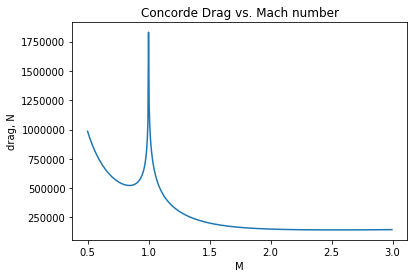

In [6]:
concorde_cruise_thrust = 150000.0 # Newtons

passenger_weight = 92080 - 78700
passenger_weight *= 0.6 # 60% of seats are filled
fuel_weight = 111130 * 0.5 # Fuel tanks are 50% full
cruise_weight = (78700 + passenger_weight + fuel_weight) * 9.7

# Wing area includes fuselage
computed_concorde_drag, a = compute_drag(rho=0.1151, v=599.44, c=295.07, L=cruise_weight,
                                         dynamic_viscosity=0.000014, T=216.65, p=7158.08,
                                         Rmax=1.66, length=61.66, wing_area=418.25,
                                         sweep_angle= 60 * np.pi/180, aspect_ratio=1.55)

print 'drag/thrust =', computed_concorde_drag / concorde_cruise_thrust

Ma = np.arange(100, 600) / 200
dr = []
for i in Ma:
    v = i * 295.07
    d = compute_drag(rho=0.1151, v=v, c=295.07, L=cruise_weight, dynamic_viscosity=0.000014,
                     T=216.65, p=7158.08, Rmax=1.66, length=63.0, wing_area=418.25,
                     sweep_angle=np.pi/3, aspect_ratio=1.7, wing=swept_wing)[0]
    dr.append(d)

plt.plot(Ma, dr)
plt.title('Concorde Drag vs. Mach number')
plt.xlabel('M')
plt.ylabel('drag, N');

Since the Concorde was built for Mach 2+ supersonic flight, we can see that the drag is lowest above Mach 2. This helps confirm our drag model.

# Model settings

All motors run at max continuous power for cruise. Electric motors can typically run at ~2x their max continuous power for a short amount of time. This can be utilized near the drag divergence Mach number, or at takeoff and landing, for a temporary boost in thrust.

The motor power density below is the continuous power density in cruise. It's assumed that the motors can temporarily increase their power output to get over the drag hump around Mach 1, similar to how the afterburners operate on the Concorde.

In [7]:
battery_specific_energy = 500 # Wh/kg
motor_specific_power = 6000 # W/kg
temporary_motor_multiplier = 2.15 # Electric motors can temporarily run at higher power
vtol_duration = 120 # seconds
weight_per_passenger = 130 # kg
battery_high_water_mark = 0.08 # Don't charge battery over 92%
battery_low_water_mark = 0.1 # Don't deplete battery under 10%
faa_reserve_time = 50 # minutes of holding for FAA compliance

mass_per_mdot = 2.0 # kg / (kg / s)
mass_per_wingfan = 2000 # kg

inlet_efficiency = 0.99
motor_efficiency = 0.96
compressor_efficiency = 0.83 # Two-stage, 91% efficiency per stage
nozzle_efficiency = 0.99
wingfan_efficiency = 0.85
max_wingfan_proportion = 0.5 # Wingfans can't account for > 50% of wing area (incl. fuselage)

# Concorde
#length = 61.66 # m
#Rmax = 1.66 # m
#concorde_empty_mass = 78700 # kg
#max_concorde_fuel_mass = 95680 # kg
#concorde_num_passengers = 100

# 787
length = 56.72 # m
Rmax = 2.91 # m
concorde_empty_mass = 119950 # kg
max_concorde_fuel_mass = 101323 # kg
concorde_num_passengers = 200

max_concorde_fuel_vol = max_concorde_fuel_mass / 810 # m^3
max_battery_mass = max_concorde_fuel_vol * 1000 * 2.6 * 1.30 # 30% more space for batteries

#concorde_wing_mass = compute_wing_mass(358.25+60, 1.55, 1.0)
concorde_wing_mass = compute_wing_mass(410, 10.03, 1.0)

# Airplanes were heavier in the 60's!
# Assume wings and fuselage are 15% lighter now
#other_mass = ((concorde_empty_mass - 3200 * 4 - 1.15 * concorde_wing_mass) * 0.85) # Concorde

other_mass = (concorde_empty_mass - 5850 * 2 - 1.00 * concorde_wing_mass) * 0.98 # 787

max_power = 5e6 # 5 MW
max_engines = 40
max_wingfans = 30

bounds = {
            'altitude': (0, 50000),
            'airspeed': (250, 340),
            'scale': (0.01, 1.5),
            'battery_mass': (1, max_battery_mass),
            'mdot': (0.1, 250.0),
            'power': (1, max_power),
            'wing_area': (0, 1500),
            'sweep_angle': (0, np.pi/2 * 0.99),
            'aspect_ratio': (0, 13),
            'wingfan_diameter_frac': (0.001, 0.7),
            'num_engines': (2, max_engines),
            'num_wingfans': (0, max_wingfans),
            'holding_altitude': (1000, 5000),
            'holding_airspeed': (30, 200),
            'holding_power': (1, max_power) # Always use all engines in hold b/c it maximizes mdot
         }

# Given a plane, output the performance of that plane

In [8]:
def compute_flight(altitude, airspeed, scale, battery_mass, mdot, power, wing_area, sweep_angle,
                   aspect_ratio, wingfan_diameter_frac, num_engines, num_wingfans,
                   holding_altitude, holding_airspeed, holding_power,
                   length=length, Rmax=Rmax, mass_per_wingfan=mass_per_wingfan,
                   other_mass=other_mass, **k):

    mass_per_wingfan *= scale ** 3
    other_mass *= scale ** 3
    length = length * scale
    Rmax = Rmax * scale

    battery_mass *= scale ** 3
    mdot *= scale ** 2
    wing_area *= scale ** 2

    # Get atmosphere conditions at altitude
    T, P, rho, c, u = atmosphere(altitude)

    # Convert # of engines & wingfans to int
    num_engines = int(np.rint(num_engines / 2)) * 2
    num_wingfans = int(np.rint(num_wingfans / 2)) * 2

    # Get plane mass
    passenger_mass = weight_per_passenger * concorde_num_passengers * scale ** 2
    num_motors = max(num_engines, num_wingfans)
    motor_mass = power / motor_specific_power * num_motors
    wing_mass = compute_wing_mass(wing_area, aspect_ratio, scale)
    compressor_mass = mdot * num_engines * mass_per_mdot
    wingfan_mass = num_wingfans * wingfan_diameter_frac ** 2 * mass_per_wingfan
    mass = other_mass + passenger_mass + battery_mass + motor_mass + wing_mass + compressor_mass + wingfan_mass

    # Get required lift
    lift = mass * gravitational_constant * earth_mass / (earth_radius + altitude) ** 2
    lift -= mass * airspeed ** 2 / (earth_radius + altitude)

    drag, min_wing_dimension = compute_drag(rho=rho, v=airspeed, c=c, L=lift,
                                            dynamic_viscosity=u, T=T, p=P, Rmax=Rmax,
                                            length=length, wing_area=wing_area,
                                            sweep_angle=sweep_angle, aspect_ratio=aspect_ratio)

    engine = get_engine(power, T, rho, P, mdot, airspeed,
                        inlet_efficiency, motor_efficiency, compressor_efficiency, nozzle_efficiency)

    mdot_ground = mdot * rho_ground / rho * 150 / airspeed # Scale VTOL mdot, set intake to 150 m/s (approximation)
    engine_vtol = get_engine(power * temporary_motor_multiplier, T_ground,
                             rho_ground, P_ground, mdot_ground, 0, inlet_efficiency,
                             motor_efficiency, compressor_efficiency, nozzle_efficiency)

    wingfan_thrust = propeller_thrust(min_wing_dimension * wingfan_diameter_frac,
                                      power * motor_efficiency * temporary_motor_multiplier,
                                      rho_ground) * wingfan_efficiency

    wingfan_area = np.pi * (min_wing_dimension * wingfan_diameter_frac / 2) ** 2
    wingfan_area *= num_wingfans

    vtol_engines_on = max(num_engines - num_wingfans, 0)
    vtol_wingfans_on = min(num_wingfans, num_engines)
    vtol_total_units = vtol_engines_on + vtol_wingfans_on
    thrust_ground = vtol_engines_on * engine_vtol['thrust']
    thrust_ground += vtol_wingfans_on * wingfan_thrust
    TWR_ground = thrust_ground / (mass * 9.81)

    # FAA reserves holding period
    T_h, P_h, rho_h, c_h, u_h = atmosphere(holding_altitude)
    holding_drag, _ = compute_drag(rho=rho_h, v=holding_airspeed, c=c_h, L=lift,
                                   dynamic_viscosity=u_h, T=T_h, p=P_h, Rmax=Rmax,
                                   length=length, wing_area=wing_area,
                                   sweep_angle=sweep_angle, aspect_ratio=aspect_ratio)

    holding_mdot = mdot * rho_h / rho * holding_airspeed / airspeed # Scale mdot for holding, approximation
    holding_engine = get_engine(holding_power, T_h, rho_h, P_h, holding_mdot, holding_airspeed,
                                inlet_efficiency, motor_efficiency, compressor_efficiency, nozzle_efficiency)
    holding_energy = holding_power * num_engines * faa_reserve_time * 60 # J
    holding_energy /= 3600 # Wh

    battery_low_water_mark_energy = battery_low_water_mark * battery_mass * battery_specific_energy # Wh

    max_lwm_holding = max(battery_low_water_mark_energy, holding_energy) # These intersect

    # VTOL energy requirements
    vtol_energy = power * temporary_motor_multiplier * num_engines * vtol_duration # J
    vtol_energy /= 3600 # Wh
    flight_energy = battery_mass * battery_specific_energy * (1 - battery_high_water_mark)
    flight_energy -= vtol_energy
    flight_energy -= max_lwm_holding

    if (engine['thrust'] * num_engines > drag and # cruise thrust must be greater than drag
        holding_engine['thrust'] * num_engines > holding_drag and # hold thrust must be greater than drag
        TWR_ground > max(vtol_total_units / (vtol_total_units - 2.01), 1) and # can lose 2 engines and still VTOL
        flight_energy > 0 and
        wingfan_area < max_wingfan_proportion * wing_area): # wingfans can't be too large

        flight_duration = flight_energy / (power * num_engines) # hours
        flight_distance = flight_duration * 3600 * airspeed / 1000 # km

        return {'flight_distance': flight_distance,
                'flight_duration': flight_duration,
                'thrust': engine['thrust'] * num_engines,
                'PR_comp': engine['PR_comp'],
                'thrust_ground': thrust_ground,
                'TWR_ground': TWR_ground,
                'cell_mass_frac': battery_mass / mass,
                'thrust/drag': engine['thrust'] * num_engines / drag,
                'lift/drag': lift / drag,
                'engine_eff': engine['engine_eff'],
                'wing_loading': lift / wing_area,
                'min_charge': holding_energy / (battery_mass * battery_specific_energy)}

    else:
        return {'flight_distance': -1}

def compute_flight_apply(x):
    return compute_flight(**x.to_dict())

def compute_flight_opt(x):
    r = compute_flight(*x)['flight_distance']
    if r < 0:
        return r ** 2
    else:
        return - r**2

In [9]:
import warnings
warnings.filterwarnings('error')

Automatic pdb calling has been turned ON


# Optimize plane over all variables
We are optimizing for distance traveled.

In [11]:
opt_vars = ['altitude', 'airspeed', 'scale', 'battery_mass', 'mdot', 'power', 'wing_area',
            'sweep_angle', 'aspect_ratio', 'wingfan_diameter_frac', 'num_engines', 'num_wingfans',
            'holding_altitude', 'holding_airspeed', 'holding_power']
opt_bounds = [bounds[b] for b in opt_vars]

planes = pd.DataFrame()

while len(planes) < 10:
    o = optimize.differential_evolution(compute_flight_opt, popsize=3, strategy='randtobest1bin',
                                        maxiter=2000, tol=0.001,
                                        bounds=opt_bounds, polish=True, init='random')
    params = dict(zip(opt_vars, o.x))

    params['battery_mass'] *= params['scale'] ** 3
    params['mdot'] *= params['scale'] ** 2
    params['wing_area'] *= params['scale'] ** 2
    #params['power'] *= params['scale'] ** 3
    #params['holding_power'] *= params['scale'] ** 3

    params.update(compute_flight(*o.x))

    if params['flight_distance'] > 0:
        print 'found plane: %s km' % params['flight_distance']
        planes = planes.append(params, ignore_index=True)

found plane: 718.067728705 km
found plane: 800.273128463 km
found plane: 858.381494625 km
found plane: 771.256967769 km
found plane: 800.961495505 km
found plane: 849.650206835 km
found plane: 752.092318422 km
found plane: 803.494242827 km
found plane: 842.797022412 km
found plane: 808.819181367 km


In [12]:
planes.set_index('flight_distance').sort_index(ascending=False)

,PR_comp,TWR_ground,airspeed,altitude,aspect_ratio,battery_mass,cell_mass_frac,engine_eff,flight_duration,holding_airspeed,holding_altitude,holding_power,lift/drag,mdot,min_charge,num_engines,num_wingfans,power,scale,sweep_angle,thrust,thrust/drag,thrust_ground,wing_area,wing_loading,wingfan_diameter_frac
flight_distance,,,,,,,,,,,,,,,,,,,,,,,,,,
858.381495,1.340122,1.077570,287.551514,9906.664224,5.977929,24375.641052,0.615685,0.721798,0.829206,146.799041,4037.053336,89232.694777,15.194198,12.392134,0.170834,27.032854,27.242817,3.619785e+05,0.387533,0.410941,25441.385860,1.000000,4.185159e+05,222.935076,1733.964173,0.629370
849.650207,1.224839,1.072016,288.772523,8876.998060,4.806306,29877.630476,0.630985,0.735382,0.817301,149.294808,2562.829403,108393.984488,14.729687,20.177137,0.181397,29.545960,29.837247,4.137333e+05,0.414369,0.071489,31608.125777,1.006720,4.979632e+05,251.268828,1840.539131,0.501669
842.797022,1.249347,1.111761,285.120406,9935.545969,4.310342,24176.349900,0.633468,0.732932,0.821093,145.406750,4423.696514,128201.247973,14.407791,22.960823,0.176758,19.557385,19.896242,5.031834e+05,0.385355,0.430599,25869.728366,1.000221,4.162428e+05,222.198919,1677.070634,0.636181
808.819181,1.289525,1.072153,330.146789,13981.052160,7.608953,50852.392910,0.588844,0.721258,0.680522,145.147877,4556.574484,144191.553285,14.652395,33.988478,0.141775,30.043427,29.728670,8.768777e+05,0.493690,0.521608,57470.360369,1.000364,9.083165e+05,365.261563,2304.573921,0.698356
803.494243,1.274479,1.091981,296.949706,7921.625598,4.481362,44455.949497,0.630254,0.730049,0.751618,147.418769,3427.074246,195281.947334,13.994305,32.909973,0.175708,24.969671,24.486265,8.373011e+05,0.473380,0.205664,49403.972910,1.003334,7.556112e+05,334.479037,2060.148778,0.551404
800.961496,1.300881,1.077469,333.691461,14636.209076,7.485184,47376.512970,0.590656,0.719760,0.666752,145.175314,4653.256145,144728.197299,14.538551,33.188344,0.142560,28.889864,27.979862,8.907169e+05,0.482889,0.522890,53794.783992,1.000587,8.478178e+05,349.282938,2237.840222,0.697829
800.273128,1.299035,1.078735,329.158817,14176.594191,7.310655,48758.112038,0.593148,0.721060,0.675352,145.497662,4521.125600,149844.344476,14.433255,34.103169,0.143417,27.871249,28.358455,9.051391e+05,0.486792,0.521809,55518.678849,1.000134,8.698967e+05,354.871598,2257.739454,0.699240
771.256968,1.308292,1.088227,327.658701,13529.956786,6.708978,57301.756446,0.597732,0.720910,0.653845,148.789004,2552.068661,197458.204356,13.957563,42.971741,0.149324,26.085245,26.912579,1.170555e+06,0.514378,0.508190,66961.443979,1.000038,1.023411e+06,392.323634,2382.173352,0.696835
752.092318,1.341051,1.092213,333.432356,13032.673660,6.144604,71268.596830,0.598915,0.717556,0.626557,148.319880,2925.164506,271196.425589,13.774935,54.307600,0.152211,24.167675,23.036960,1.632691e+06,0.552586,0.522210,84326.322491,1.001205,1.274997e+06,457.494215,2535.971247,0.699211


## As we can see above, a VTOL subsonic plane with a 500 Wh/kg battery pack could go about 850 km.

The optimizer can also compute flight performance at supersonic airspeeds. A supersonic plane would have more drag, and therefore not travel as far, so it seems like a supersonic plane is not feasible. Supersonic electric VTOL jets would likely start to become practical at about 1000-1500 Wh/kg.